# **Đọc dữ liệu từ Google Drive**

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LogisticRegression
import os
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

# **1. Tự xây dựng chương trình tính HOG feature vector từ NUMPY**

In [3]:
class Hog_descriptor():
    def __init__(self, img, cell_size=16, bin_size=8):
        self.img = img
        self.img = np.sqrt(img / float(np.max(img)))
        self.img = self.img * 255
        self.cell_size = cell_size
        # in slides, bin_size = 9
        self.bin_size = bin_size
        self.angle_unit = 360 / self.bin_size
        assert type(self.bin_size) == int
        assert type(self.cell_size) == int

    # Compute Gradients of hole image-patch, use sobel mask
    def global_gradient(self):
        gradient_values_x = cv2.Sobel(self.img, cv2.CV_64F, 1, 0, ksize=5)
        gradient_values_y = cv2.Sobel(self.img, cv2.CV_64F, 0, 1, ksize=5)
        gradient_magnitude = cv2.addWeighted(gradient_values_x, 0.5, gradient_values_y, 0.5, 0)
        gradient_angle = cv2.phase(gradient_values_x, gradient_values_y, angleInDegrees=True)
        return gradient_magnitude, gradient_angle
    def extract(self):
        height, width = self.img.shape
        gradient_magnitude, gradient_angle = self.global_gradient()
        gradient_magnitude = abs(gradient_magnitude)
        cell_gradient_vector = np.zeros((int(height / self.cell_size), int(width / self.cell_size),

        self.bin_size))

        for i in range(cell_gradient_vector.shape[0]):
            for j in range(cell_gradient_vector.shape[1]):
                cell_magnitude = gradient_magnitude[i * self.cell_size:(i + 1) * self.cell_size,
                j * self.cell_size:(j + 1) * self.cell_size]
                cell_angle = gradient_angle[i * self.cell_size:(i + 1) * self.cell_size,
                j * self.cell_size:(j + 1) * self.cell_size]
                cell_gradient_vector[i][j] = self.cell_gradient(cell_magnitude, cell_angle)
        hog_image = self.render_gradient(np.zeros([height, width]), cell_gradient_vector)
        hog_vector = []

        for i in range(cell_gradient_vector.shape[0] - 1):
            for j in range(cell_gradient_vector.shape[1] - 1):
                block_vector = []
                block_vector.extend(cell_gradient_vector[i][j])
                block_vector.extend(cell_gradient_vector[i][j + 1])
                block_vector.extend(cell_gradient_vector[i + 1][j])
                block_vector.extend(cell_gradient_vector[i + 1][j + 1])
                mag = lambda vector: math.sqrt(sum(i ** 2 for i in vector))
                magnitude = mag(block_vector)
                if magnitude != 0:
                    normalize = lambda block_vector, magnitude: [element / magnitude for element in

                    block_vector]

                    block_vector = normalize(block_vector, magnitude)
                hog_vector.append(block_vector)
        return hog_vector, hog_image
    def cell_gradient(self, cell_magnitude, cell_angle):
        orientation_centers = [0] * self.bin_size
        for i in range(cell_magnitude.shape[0]):
            for j in range(cell_magnitude.shape[1]):
                gradient_strength = cell_magnitude[i][j]
                gradient_angle = cell_angle[i][j]
                min_angle, max_angle, mod = self.get_closest_bins(gradient_angle)
                orientation_centers[min_angle] += (gradient_strength * (1 - (mod / self.angle_unit)))
                orientation_centers[max_angle] += (gradient_strength * (mod / self.angle_unit))
        return orientation_centers
    def get_closest_bins(self, gradient_angle):
        idx = int(gradient_angle / self.angle_unit)
        mod = gradient_angle % self.angle_unit
        if idx == self.bin_size:
            return idx - 1, (idx) % self.bin_size, mod
        return idx, (idx + 1) % self.bin_size, mod
    def render_gradient(self, image, cell_gradient):
        cell_width = self.cell_size / 2
        max_mag = np.array(cell_gradient).max()
        for x in range(cell_gradient.shape[0]):
            for y in range(cell_gradient.shape[1]):
                cell_grad = cell_gradient[x][y]
                cell_grad /= max_mag
                angle = 0
                angle_gap = self.angle_unit
                for magnitude in cell_grad:
                    angle_radian = math.radians(angle)
                    x1 = int(x * self.cell_size + magnitude * cell_width * math.cos(angle_radian))
                    y1 = int(y * self.cell_size + magnitude * cell_width * math.sin(angle_radian))
                    x2 = int(x * self.cell_size - magnitude * cell_width * math.cos(angle_radian))
                    y2 = int(y * self.cell_size - magnitude * cell_width * math.sin(angle_radian))
                    cv2.line(image, (y1, x1), (y2, x2), int(255 * math.sqrt(magnitude)))
                    angle += angle_gap
        return image

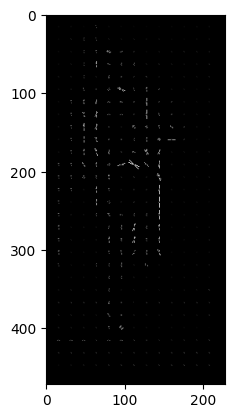

In [4]:
img = cv2.imread("bolt.png", cv2.IMREAD_GRAYSCALE)
hog = Hog_descriptor(img, cell_size=16, bin_size=16)
vector, image = hog.extract()
plt.imshow(image, cmap="gray")
plt.show()

In [5]:
vector

[[0.004589927013029812,
  0.013266310917971525,
  0.0049703607332313715,
  0.0010322468321340948,
  0.004397463803908018,
  0.0012101262337035766,
  0.000507113891740433,
  0.030320880852382253,
  0.38629072521628105,
  0.05453636963378033,
  0.0578751704336278,
  0.10958697492314261,
  0.4560499352885689,
  0.012170544236657874,
  0.000669735954819661,
  0.0013606798446873377,
  0.009006929763951609,
  0.007441260158620988,
  0.019006504178480408,
  0.013212391801549867,
  0.009408724132026328,
  0.004301896331331129,
  0.0021436820351169636,
  0.0015996734963072284,
  0.0009236311170913034,
  0.0,
  0.0,
  0.008588181645695319,
  0.6159713985377018,
  0.008715046692596297,
  9.30862793713135e-05,
  0.0,
  0.000895810391167822,
  0.002257031740964573,
  0.0033600834459549147,
  0.010586189369605814,
  0.021387723184611494,
  0.005448201648241646,
  0.0012262966418795018,
  0.03156667373901287,
  0.4872457171196095,
  0.03866787819902417,
  0.009164533429340415,
  0.005654469284425321,

In [6]:
# 1. Khai báo các tham số
cell_size = (8, 8) # h x w in pixels
block_size = (2, 2) # h x w in cells
nbins = 9 # number of orientation bins
# 2. Tính toán các tham số truyền vào HOGDescriptor
# winSize: Kích thước của bức ảnh được crop để chia hết cho cell size.
winSize = (img.shape[1] // cell_size[1] * cell_size[1], img.shape[0] // cell_size[0] *

cell_size[0])

# blockSize: Kích thước của 1 block
blockSize = (block_size[1] * cell_size[1], block_size[0] * cell_size[0])
# blockStride: Số bước di chuyển của block khi thực hiện chuẩn hóa histogram bước 3
blockStride = (cell_size[1], cell_size[0])
n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])

# **2. Sử dụng thư viện OpenCV**

In [7]:
hog = cv2.HOGDescriptor(_winSize=winSize,
                        _blockSize=blockSize,
                        _blockStride=blockStride,
                        _cellSize=cell_size,
                        _nbins=nbins)

In [8]:
hog

< cv2.HOGDescriptor 000002D28CF9AD10>

In [9]:
hog_feats = hog.compute(img).reshape(n_cells[1] - block_size[1] + 1,
                                    n_cells[0] - block_size[0] + 1,
                                    block_size[0], block_size[1], nbins).transpose((1, 0, 2, 3, 4))

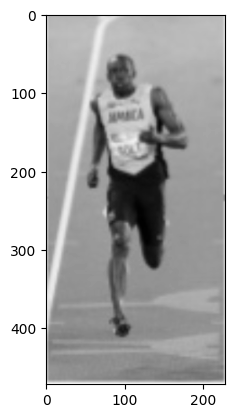

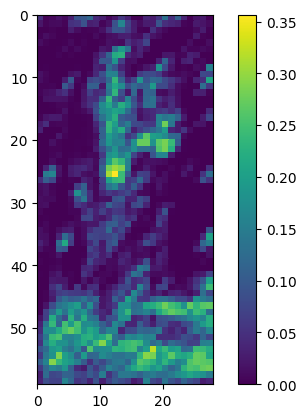

In [10]:
img = cv2.cvtColor(cv2.imread("bolt.png"), cv2.COLOR_BGR2GRAY)

cell_size = (8, 8) # h x w in pixels
block_size = (2, 2) # h x w in cells
nbins = 9 # number of orientation bins

# winSize is the size of the image cropped to an multiple of the cell size
hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                        img.shape[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                        block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)

n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])
hog_feats = hog.compute(img)\
            .reshape(n_cells[1] - block_size[1] + 1,
            n_cells[0] - block_size[0] + 1,
            block_size[0], block_size[1], nbins) \
            .transpose((1, 0, 2, 3, 4)) # index blocks by rows first
# hog_feats now contains the gradient amplitudes for each direction,
# for each cell of its group for each group. Indexing is by rows then columns.

gradients = np.zeros((n_cells[0], n_cells[1], nbins))

# count cells (border cells appear less often across overlapping groups)
cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

for off_y in range(block_size[0]):
    for off_x in range(block_size[1]):
        gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                off_x:n_cells[1] - block_size[1] + off_x + 1] += \
                hog_feats[:, :, off_y, off_x, :]
        cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

# Average gradients
gradients /= cell_count

# Preview
plt.figure()
plt.imshow(img, cmap='gray')
plt.show()

bin = 5 # angle is 360 / nbins * direction
plt.pcolor(gradients[:, :, bin])
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.show()

# **3. Sử dụng mô hình logistic regression để phân loại ảnh chó, mèo**

In [11]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [12]:
def write_feature_vector(temp, files, vector):
    with open(files, 'a') as file:
        file.write(temp + "\t")
        for i in vector:
             file.write(str(i) + "\t")
        file.write("\n")
        file.close()

In [13]:
def hog_feature(img) :
    cell_size = (8, 8) # h x w in pixels
    block_size = (2, 2) # h x w in cells
    nbins = 9 # number of orientation bins
    # 2. Tính toán các tham số truyền vào HOGDescriptor
    # winSize: Kích thước của bức ảnh được crop để chia hết cho cell size.
    winSize = (img.shape[1] // cell_size[1] * cell_size[1], img.shape[0] // cell_size[0] *

                cell_size[0])

    # blockSize: Kích thước của 1 block
    blockSize = (block_size[1] * cell_size[1], block_size[0] * cell_size[0])
    # blockStride: Số bước di chuyển của block khi thực hiện chuẩn hóa histogram bước 3
    blockStride = (cell_size[1], cell_size[0])
    n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])
    hog = cv2.HOGDescriptor(_winSize=winSize,
                        _blockSize=blockSize,
                        _blockStride=blockStride,
                        _cellSize=cell_size,
                        _nbins=nbins)
    hog_feats = hog.compute(img).reshape(n_cells[1] - block_size[1] + 1,
                                    n_cells[0] - block_size[0] + 1,
                                    block_size[0], block_size[1], nbins).transpose((1, 0, 2, 3, 4))
    hog_feats = hog_feats.flatten()
    return hog_feats 

In [14]:
images_cats = load_images_from_folder("cats_and_dogs_filtered/train/cats")
images_dogs = load_images_from_folder("cats_and_dogs_filtered/train/dogs")
feature_vector = []
for image_cat in images_cats:
    image_cat = cv2.resize(image_cat, (64, 128))
    hog_feats_cat = hog_feature(image_cat)
    print("đặc trưng", hog_feats_cat)
    write_feature_vector("1", "training.txt", hog_feats_cat)
for image_dog in images_dogs:
    image_dog = cv2.resize(image_dog, (64, 128))
    hog_feats_dog = hog_feature(image_dog)
    print(hog_feats_dog)
    write_feature_vector("2", "training.txt", hog_feats_dog)

đặc trưng [0.2503882  0.04183272 0.01559046 ... 0.06891266 0.17791303 0.20849517]
đặc trưng [0.24158458 0.09531556 0.13908784 ... 0.06267046 0.07628934 0.19900036]
đặc trưng [0.07288399 0.07394719 0.10117138 ... 0.09176698 0.1885433  0.30712107]
đặc trưng [0.06042082 0.05223367 0.02313981 ... 0.0601162  0.06781732 0.31274396]
đặc trưng [0.23470071 0.10668179 0.07775962 ... 0.07776199 0.11232539 0.24534182]
đặc trưng [0.21765304 0.1297416  0.17936984 ... 0.12750387 0.2508419  0.25233513]
đặc trưng [0.18217798 0.08729646 0.06589642 ... 0.04024928 0.2514502  0.2514502 ]
đặc trưng [0.22515294 0.17526673 0.09632338 ... 0.0117032  0.00939513 0.04089997]
đặc trưng [0.31966096 0.1682854  0.02758645 ... 0.26961076 0.15596423 0.06826375]
đặc trưng [0.06066203 0.08006023 0.10951427 ... 0.13144411 0.1707407  0.21976839]
đặc trưng [0.10816725 0.19558614 0.19404665 ... 0.25714836 0.25714836 0.25714836]
đặc trưng [0.18396547 0.18695849 0.10514995 ... 0.02557123 0.14144589 0.33812514]
đặc trưng [0.147

In [15]:
def center_crop(image_path, size):
  """
  crop the image from center of the given size
  input:
    image_path (string): Path of image
    size (int): size to which the image being cropped from center
  """
  img = Image.open(image_path)
  img = img.resize((size+1,size+1))
  x_center = img.width/2
  y_center = img.height/2
  size = size/2
  cr = img.crop((x_center-size, y_center-size, x_center+size, y_center+size))

  return cr

In [16]:
img = Image.open("cats_and_dogs_filtered/train/cats/cat.0.jpg")
img.format, type(img)

('JPEG', PIL.JpegImagePlugin.JpegImageFile)

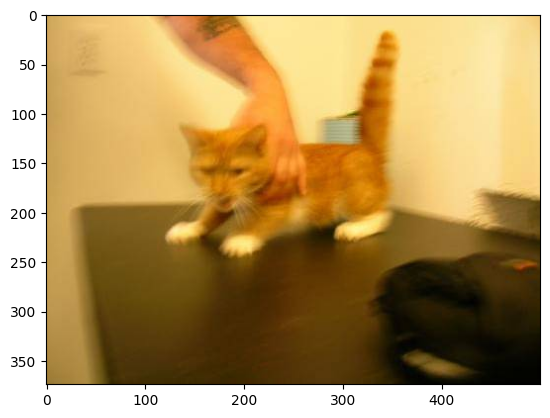

In [17]:
plt.imshow(img)

**Chuẩn bị dữ liệu cho ảnh chó mèo**

In [18]:
cat_list = os.listdir("cats_and_dogs_filtered/train/cats")
dog_list = os.listdir("cats_and_dogs_filtered/train/dogs")

In [19]:
cat_list = cat_list[:300]
dog_list = dog_list[:300]

In [20]:
len(cat_list), len(dog_list)

(300, 300)

In [21]:
train_list = []
train_list.extend(cat_list)
train_list.extend(dog_list)

In [22]:
np.random.shuffle(train_list)

In [23]:
## shuffled version of `train_list`
train_list[:10]

['dog.310.jpg',
 'cat.154.jpg',
 'dog.108.jpg',
 'cat.141.jpg',
 'cat.230.jpg',
 'dog.289.jpg',
 'dog.142.jpg',
 'dog.178.jpg',
 'cat.335.jpg',
 'cat.13.jpg']

**Chuẩn bị dữ liệu training**

In [24]:
train_data = np.zeros((600, 30000))

In [25]:
for i, image_name in enumerate(train_list):
  if image_name.split(".")[0] == "dog":
    path =  "cats_and_dogs_filtered/train/dogs"
  else:
    path =  "cats_and_dogs_filtered/train/cats"
  image_path = f'{path}/{image_name}'
  crp_img = center_crop(image_path, 100)
  crp_arr = np.array(crp_img).reshape(-1)
  train_data[i] = crp_arr

In [26]:
train_data[0]

array([ 88., 118.,  54., ...,  99., 119.,  67.])

In [27]:
train_data = train_data/255

In [28]:
train_data[0]

array([0.34509804, 0.4627451 , 0.21176471, ..., 0.38823529, 0.46666667,
       0.2627451 ])

**Đánh nhãn dữ liệu**

In [29]:
print("printing the name of some image")
print("-> ",train_list[0])
print("Splitting the image from all . characters into a list")
print("-> ",train_list[0].split("."))
print("selecting the 0th element of splitted list")
print("-> ",train_list[0].split(".")[0])

printing the name of some image
->  dog.310.jpg
Splitting the image from all . characters into a list
->  ['dog', '310', 'jpg']
selecting the 0th element of splitted list
->  dog


In [30]:
# cat: 0
# dog: 1
train_labels = np.array([0 if name.split(".")[0]=="cat" else 1 for name in train_list])

In [31]:
train_labels.shape

(600,)

**Training mô hình Logistic Regression**

In [32]:
model = LogisticRegression(max_iter=100, n_jobs=-1)

In [33]:
model.fit(train_data, train_labels)

LogisticRegression(n_jobs=-1)

In [34]:
model.score(train_data, train_labels)

1.0

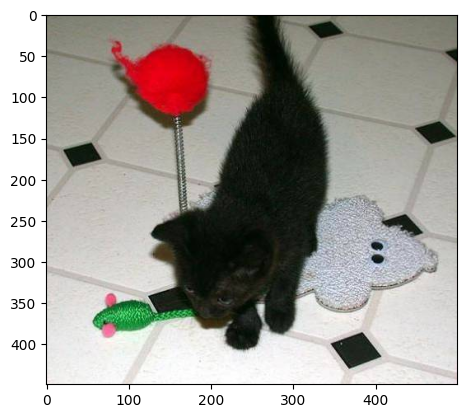

In [35]:
# Predicting an image to see the result
test_img = "cats_and_dogs_filtered/validation/cats/cat.2002.jpg"
img = Image.open(test_img)
plt.imshow(img)

In [36]:
im = center_crop(test_img, 100) # cropping image
X = np.array(im).reshape(-1) # flattening the image to pass in model for prediction
X = X/255 # scale the pixels in 0-1 range

In [37]:
model.predict([X])

array([0])

**Phân tích kết quả training**

In [38]:
train_pred = model.predict(train_data)
cm = confusion_matrix(train_pred, train_labels)
cm

array([[300,   0],
       [  0, 300]], dtype=int64)

<AxesSubplot:>

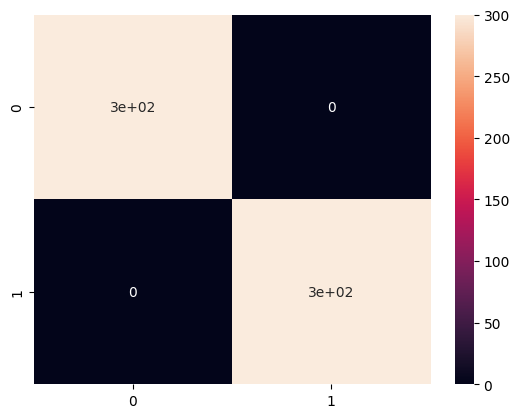

In [39]:
sns.heatmap(cm, annot=True)

**Chuẩn bị cho dữ liệu test**

In [40]:
test_data_cat = os.listdir("cats_and_dogs_filtered/validation/cats")
test_data_dog = os.listdir("cats_and_dogs_filtered/validation/dogs")

In [41]:
test_data_cat = test_data_cat[:200]
test_data_dog = test_data_dog[:200]

In [42]:
test_list = []
test_list.extend(test_data_cat)
test_list.extend(test_data_dog)

In [43]:
len(test_list)

400

In [44]:
test_data = np.zeros((400, 30000))

In [45]:
for i, image_name in enumerate(test_list):
  if image_name.split(".")[0] == "dog":
    path =  "cats_and_dogs_filtered/validation/dogs"
  else:
    path =  "cats_and_dogs_filtered/validation/cats"
  image_path = f'{path}/{image_name}'
  crp_img = center_crop(image_path, 100)
  crp_arr = np.array(crp_img).reshape(-1)
  test_data[i] = crp_arr

In [46]:
test_data = test_data/255

In [47]:
test_labels = np.array([0 if name.split(".")[0]=="cat" else 1 for name in test_list])

**Phân tích kết quả test**

[[125  92]
 [ 75 108]]


<AxesSubplot:>

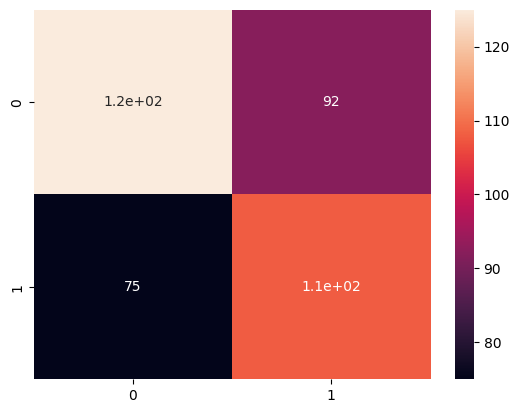

In [48]:
pred = model.predict(test_data)
cm = confusion_matrix(pred, test_labels)
print(cm)
sns.heatmap(cm, annot=True)

**Độ chính xác của mô hình**

In [49]:
test_acc = model.score(test_data, test_labels)
print("Accuracy on test set: ", test_acc)

Accuracy on test set:  0.5825


**Test ảnh chó mèo**

In [50]:
def show_image(img_path):
    img = Image.open(img_path)
    plt.imshow(img)

In [51]:
def predict_custom_image(model, img_path):
    crp_img = center_crop(img_path,100)
    crp_arr = np.array(crp_img).reshape(1,-1)
    pred = model.predict(crp_arr)
    if pred == 0:
        return "Cat"
    return "Dog"

'Cat'

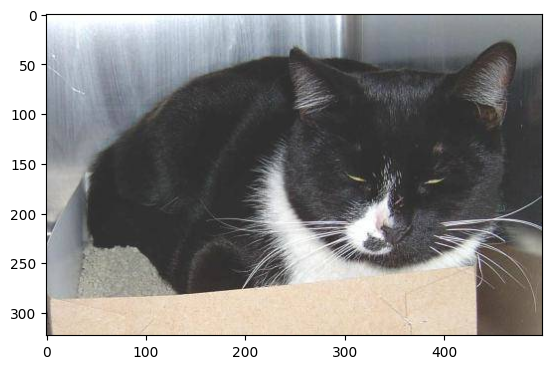

In [56]:
test_img_path = "cats_and_dogs_filtered/validation/cats/cat.2001.jpg" # provide path to your custom image (make sure it's either jpg or jpeg)
show_image(test_img_path)
predict_custom_image(model, test_img_path)

'Dog'

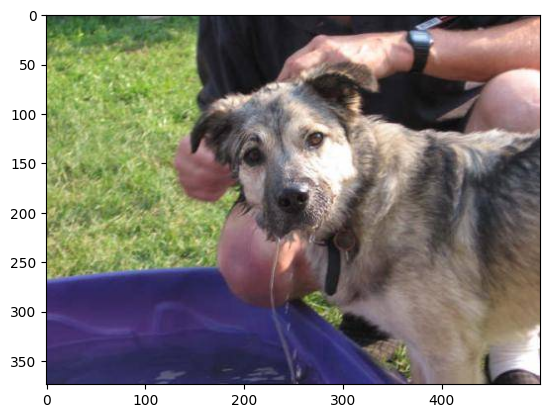

In [57]:
test_img_path = "cats_and_dogs_filtered/validation/dogs/dog.2004.jpg" # provide path to your custom image (make sure it's either jpg or jpeg)
show_image(test_img_path)
predict_custom_image(model, test_img_path)